# 用户消费数据分析

### 目的
1. 复购率和回购率
2. 用户质量
3. 用户生命周期
4. 留存率

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid',{'font.sans-serif':'simhei'})

#### 导入数据

In [2]:
data = pd.read_table('CDNOW_master.txt',names = ['id','date','products','amount'],sep = '\s+')
#查看前5行
data.head()

,id,date,products,amount
0,1,19970101,1,11.77
1,2,19970112,1,12.00
2,2,19970112,5,77.00
3,3,19970102,2,20.76
4,3,19970330,2,20.76


In [3]:
#查看字段信息
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
id          69659 non-null int64
date        69659 non-null int64
products    69659 non-null int64
amount      69659 non-null float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


一共有69659条数据，4个字段，数据集没有缺失值。

In [4]:
#查看描述性统计信息
data.describe()

,id,date,products,amount
count,69659.000000,6.965900e+04,69659.000000,69659.000000
mean,11470.854592,1.997228e+07,2.410040,35.893648
std,6819.904848,3.837735e+03,2.333924,36.281942
min,1.000000,1.997010e+07,1.000000,0.000000
25%,5506.000000,1.997022e+07,1.000000,14.490000
50%,11410.000000,1.997042e+07,2.000000,25.980000
75%,17273.000000,1.997111e+07,3.000000,43.700000
max,23570.000000,1.998063e+07,99.000000,1286.010000


用户每笔订单平均购买2.4个商品，中位数在2个商品，75分位数在3个商品，说明大多数订单的购买量不多。购买金额的情况也差不多，大部分订单都集中在小额。

In [5]:
#将date这一列转换为时间格式
data.date = pd.to_datetime(data.date,format = '%Y%m%d')

#提取出月份，以月份为时间窗口
data['month'] = data.date.astype('datetime64[M]')
data.head()

,id,date,products,amount,month
0,1,1997-01-01,1,11.77,1997-01-01
1,2,1997-01-12,1,12.00,1997-01-01
2,2,1997-01-12,5,77.00,1997-01-01
3,3,1997-01-02,2,20.76,1997-01-01
4,3,1997-03-30,2,20.76,1997-03-01


#### 用户角度

In [6]:
#将id groupby之后，可以看到每个用户的消费情况
id_grouped = data.groupby('id').sum()
id_grouped.head()

,products,amount
id,,
1,1,11.77
2,6,89.00
3,16,156.46
4,7,100.50
5,29,385.61


In [7]:
id_grouped.describe()

,products,amount
count,23570.000000,23570.000000
mean,7.122656,106.080426
std,16.983531,240.925195
min,1.000000,0.000000
25%,1.000000,19.970000
50%,3.000000,43.395000
75%,7.000000,106.475000
max,1033.000000,13990.930000


从用户角度看，每个用户的平均购买量是7个，标准差17，波动比较大，最多的用户购买了1033个。用户的客单价是106元，标准差240，平均值和75分位数接近，说明大多数用户消费能力不高，应该有小部分的高额消费用户。可以判定是一个右偏态，画图看一下。

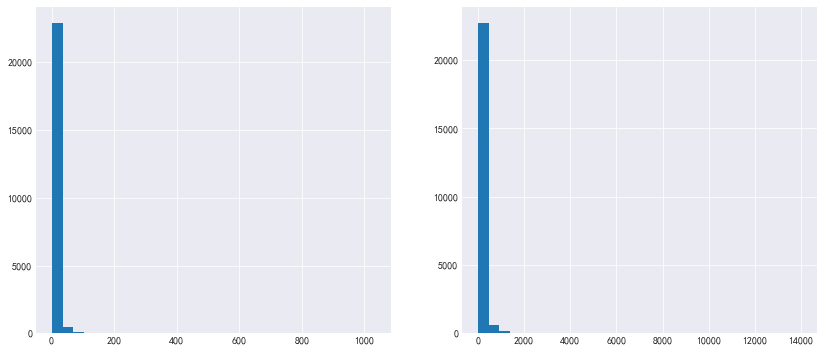

In [8]:
plt.figure(figsize = (14,6))
plt.subplot(121)
id_grouped.products.hist(bins = 30)
plt.subplot(122)
id_grouped.amount.hist(bins = 30)
plt.show()

确实是一个右偏态，大部分用户的消费能力确实不高。

#### 将月份作为维度

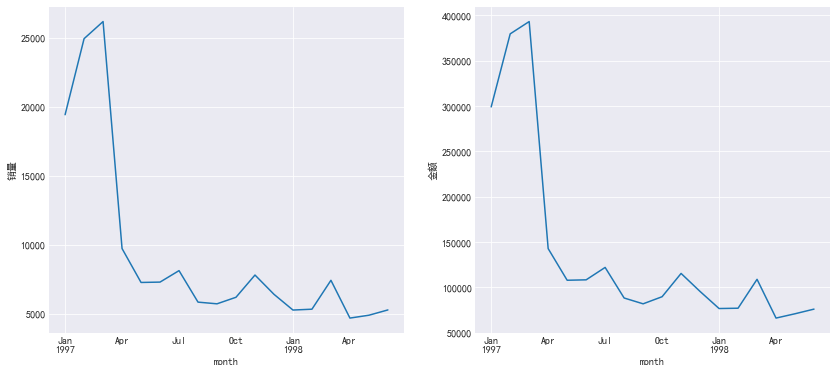

In [9]:
plt.figure(figsize = (14,6))

#绘制每个月的销量
plt.subplot(121)
data.groupby('month').products.sum().plot()
plt.ylabel('销量')

#绘制每个月的消费金额
plt.subplot(122)
data.groupby('month').amount.sum().plot()
plt.ylabel('金额')
plt.show()

按月份统计每个月的销量和金额。可以看出，前3个月的销量和金额很高，而后面几个月趋于平稳。数据很异常，是什么原因呢？

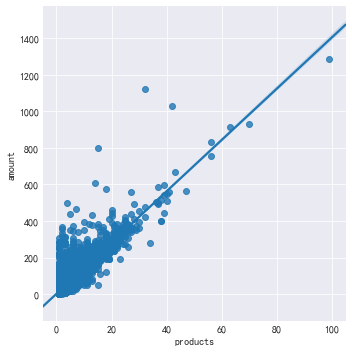

In [10]:
#绘制每笔订单的散点图
sns.lmplot(x = 'products',y = 'amount',data = data)
plt.show()

观察发现，每笔订单消费金额和数量呈现规律性，每个商品14元左右。

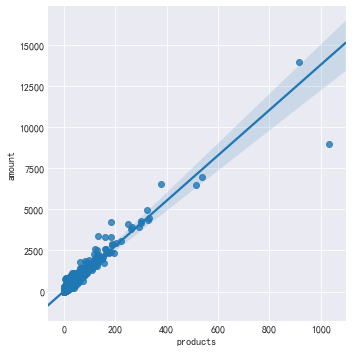

In [11]:
#绘制每个用户的散点图
sns.lmplot(x = 'products',y = 'amount',data = id_grouped)
plt.show()

绘制每个用户消费的散点图发现，用户消费都比较正常。而且规律性比上图要强。

In [12]:
#用户第一次消费时间
data.groupby('id').month.min().value_counts()

1997-02-01    8476
1997-01-01    7846
1997-03-01    7248
Name: month, dtype: int64

所有用户的第一次消费都集中在前三个月

In [13]:
#用户最后一次消费时间
data.groupby('id').month.max().value_counts()

1997-02-01    4912
1997-03-01    4478
1997-01-01    4192
1998-06-01    1506
1998-05-01    1042
1998-03-01     993
1998-04-01     769
1997-04-01     677
1997-12-01     620
1997-11-01     609
1998-02-01     550
1998-01-01     514
1997-06-01     499
1997-07-01     493
1997-05-01     480
1997-10-01     455
1997-09-01     397
1997-08-01     384
Name: month, dtype: int64

大多数用户的最后一次消费时间依然集中在前三个月，后面几个月依然后消费，但是在慢慢减少。数据异常得到了解释。

### 1.复购率和回购率

In [14]:
#用pivo_table进行数据透视
data_pivot = data.pivot_table(values = 'date',index = 'id',columns = 'month',aggfunc = 'count').fillna(0)
data_pivot.head()

month,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00
id,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


#### 复购率：指的是在某时间窗口内消费两次及以上的用户在总消费用户中的占比。

In [15]:
data_pivot_fugou = data_pivot.applymap(lambda x:1 if x > 1 else 0 if x == 1 else np.nan)
data_pivot_fugou.head()

month,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00
id,,,,,,,,,,,,,,,,,,
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN


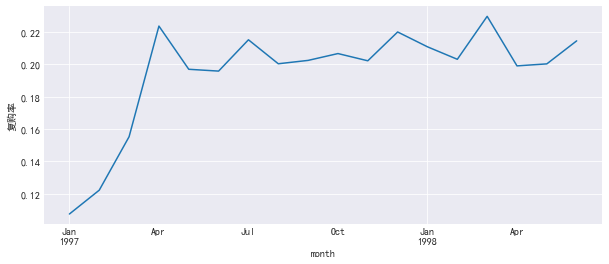

In [16]:
(data_pivot_fugou.sum() / data_pivot_fugou.count()).plot(figsize = (10,4))
plt.ylabel('复购率')
plt.show()

前面三个月的复购率并不高，说明大多数用户只消费了一次；后期的复购率大约稳定在20%左右。

#### 回购率：指的是在某时间窗口内消费的用户，在下一个时间窗口仍然消费的占比。

In [17]:
def huigou(x):
    rongqi = []
    for i in range(17):
        if x[i] >= 1:
            if x[i+1] >= 1:
                rongqi.append(1)   #若本月有消费，下个月也有消费，则记为1
            else:
                rongqi.append(0)   #若本月有消费，下个月没有消费，则记为0
                
        else:
            rongqi.append(np.nan) #若本月没有消费，则记为NaN
    rongqi.append(np.nan)
    return pd.Series(rongqi,index = data_pivot.columns)

In [18]:
data_pivot_huigou = data_pivot.apply(huigou,axis = 1)
data_pivot_huigou.head()

month,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00
id,,,,,,,,,,,,,,,,,,
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,0.0,NaN,1.0,1.0,1.0,0.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN


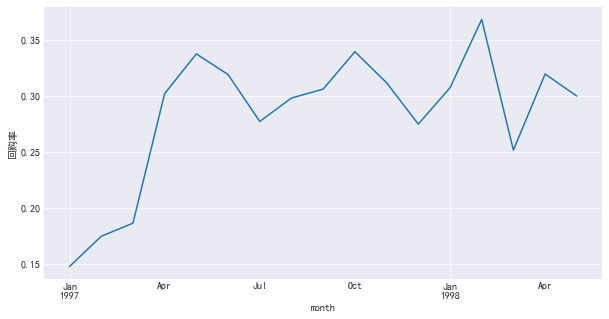

In [19]:
(data_pivot_huigou.sum() / data_pivot_huigou.count()).plot(figsize = (10,5))
plt.ylabel('回购率')
plt.show()

### 2.用户质量

##### 销售额

In [20]:
#将用户进行聚合，求出每个用户的消费金额
id_amount = data.groupby('id').amount.sum().sort_values().reset_index()
#将金额进行累加
id_amount['cumsum'] = id_amount.amount.cumsum()
#转换成百分比
id_amount['prop'] = id_amount['cumsum'] / id_amount['cumsum'].max()
id_amount[-5:]

,id,amount,cumsum,prop
23565,7931,6497.18,2463822.60,0.985405
23566,19339,6552.70,2470375.30,0.988025
23567,7983,6973.07,2477348.37,0.990814
23568,14048,8976.33,2486324.70,0.994404
23569,7592,13990.93,2500315.63,1.000000


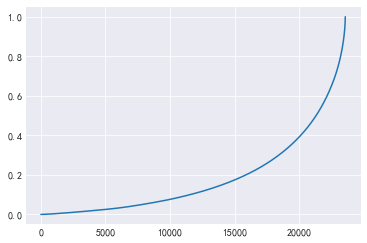

In [21]:
id_amount['prop'].plot()
plt.show()

根据趋势图，可以看到前20000个用户消费只占总金额的40%，而后面的3500个用户消费占了总金额的60%。

##### 销量

In [22]:
id_order = data.groupby('id').month.count().sort_values().reset_index()
id_order['cumsum'] = id_order['month'].cumsum()
id_order['prop'] = id_order['cumsum'] / id_order['cumsum'].max()
id_order[-5:]

,id,month,cumsum,prop
23565,3049,117,68949,0.989807
23566,22061,143,69092,0.991860
23567,7983,149,69241,0.993999
23568,7592,201,69442,0.996885
23569,14048,217,69659,1.000000


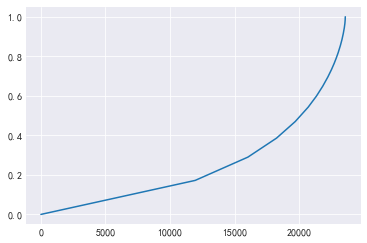

In [23]:
id_order['prop'].plot()
plt.show()

前20000个用户贡献了45%的销量，剩下的3500个用户贡献了55%的销量。

### 3.用户生命周期

In [24]:
date_min = data.groupby('id').date.min()
date_max = data.groupby('id').date.max()
#得出每个用户的生命周期
life_time = (date_max - date_min).reset_index()
life_time[:10]

,id,date
0,1,0 days
1,2,0 days
2,3,511 days
3,4,345 days
4,5,367 days
5,6,0 days
6,7,445 days
7,8,452 days
8,9,523 days
9,10,0 days


In [25]:
#用户的平均生命周期
life_time['date'].mean()

Timedelta('134 days 20:55:36.987696')

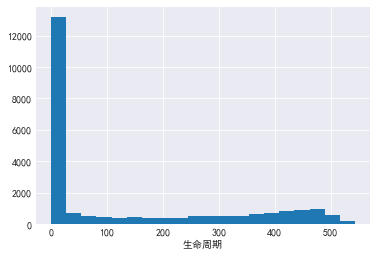

In [26]:
#将timedelta类型转换为数值类型，并画出直方图
(life_time['date'] / np.timedelta64(1,'D')).hist(bins = 20)
plt.xlabel('生命周期')
plt.show()

大部分部分的生命周期很短，因为大部分用户的消费都集中在前3个月，而且只消费了一次。

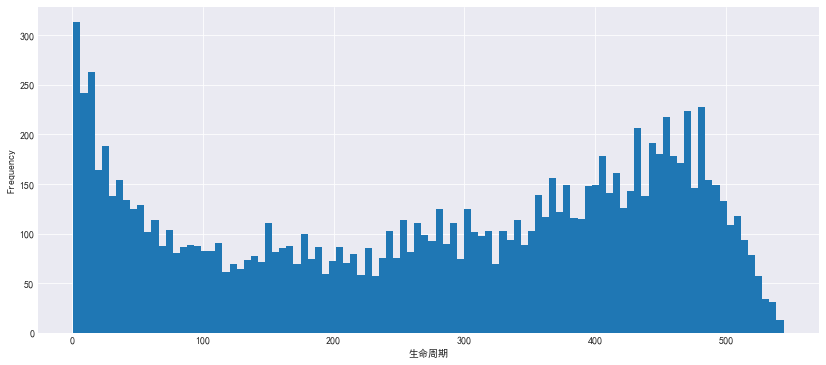

In [27]:
#将只消费了一次的用户排除，画出直方图
life_time['life'] = life_time['date'] / np.timedelta64(1,'D')
life_time['life'][life_time['life'] > 0].plot.hist(bins = 100,figsize = (14,6))
plt.xlabel('生命周期')
plt.show()

In [28]:
life_time['life'][life_time['life'] > 0].mean()

276.0448072247308

排除只消费了一次的用户之后，用户的平均生命周期为276天，比刚才好多了。

### 4.留存率

#### 留存率：指用户在第一次消费后，有多少比率进行第二次消费

In [29]:
id_retention = pd.merge(left = data,right = date_min.reset_index(),on = 'id',suffixes = ['','_min'])
id_retention.head()

,id,date,products,amount,month,date_min
0,1,1997-01-01,1,11.77,1997-01-01,1997-01-01
1,2,1997-01-12,1,12.00,1997-01-01,1997-01-12
2,2,1997-01-12,5,77.00,1997-01-01,1997-01-12
3,3,1997-01-02,2,20.76,1997-01-01,1997-01-02
4,3,1997-03-30,2,20.76,1997-03-01,1997-01-02


In [30]:
#每次消费距离第一次消费的时间差
id_retention['diffed'] = id_retention['date'] - id_retention['date_min']
#将时间差转换为数值类型
id_retention['diffed'] = id_retention['diffed'] / np.timedelta64(1,'D')
id_retention.head(10)

,id,date,products,amount,month,date_min,diffed
0,1,1997-01-01,1,11.77,1997-01-01,1997-01-01,0.0
1,2,1997-01-12,1,12.00,1997-01-01,1997-01-12,0.0
2,2,1997-01-12,5,77.00,1997-01-01,1997-01-12,0.0
3,3,1997-01-02,2,20.76,1997-01-01,1997-01-02,0.0
4,3,1997-03-30,2,20.76,1997-03-01,1997-01-02,87.0
5,3,1997-04-02,2,19.54,1997-04-01,1997-01-02,90.0
6,3,1997-11-15,5,57.45,1997-11-01,1997-01-02,317.0
7,3,1997-11-25,4,20.96,1997-11-01,1997-01-02,327.0
8,3,1998-05-28,1,16.99,1998-05-01,1997-01-02,511.0
9,4,1997-01-01,2,29.33,1997-01-01,1997-01-01,0.0


In [31]:
#将时间差进行划分
#仅消费一次，或者一天当中消费多次，后面没有消费的，留存率都视为0
bins = [0,3,7,15,30,60,90,180,365]
id_retention['diffed_bin'] = pd.cut(id_retention['diffed'],bins = bins)
id_retention.head(10)

,id,date,products,amount,month,date_min,diffed,diffed_bin
0,1,1997-01-01,1,11.77,1997-01-01,1997-01-01,0.0,NaN
1,2,1997-01-12,1,12.00,1997-01-01,1997-01-12,0.0,NaN
2,2,1997-01-12,5,77.00,1997-01-01,1997-01-12,0.0,NaN
3,3,1997-01-02,2,20.76,1997-01-01,1997-01-02,0.0,NaN
4,3,1997-03-30,2,20.76,1997-03-01,1997-01-02,87.0,"(60, 90]"
5,3,1997-04-02,2,19.54,1997-04-01,1997-01-02,90.0,"(60, 90]"
6,3,1997-11-15,5,57.45,1997-11-01,1997-01-02,317.0,"(180, 365]"
7,3,1997-11-25,4,20.96,1997-11-01,1997-01-02,327.0,"(180, 365]"
8,3,1998-05-28,1,16.99,1998-05-01,1997-01-02,511.0,NaN
9,4,1997-01-01,2,29.33,1997-01-01,1997-01-01,0.0,NaN


In [32]:
pivoted_retention = id_retention.pivot_table(values = 'amount',index = 'id',columns = 'diffed_bin',aggfunc = 'sum',dropna = False)
pivoted_retention.head(10)

diffed_bin,"(0, 3]","(3, 7]","(7, 15]","(15, 30]","(30, 60]","(60, 90]","(90, 180]","(180, 365]"
id,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,40.3,NaN,78.41
4,NaN,NaN,NaN,29.73,NaN,NaN,NaN,41.44
5,NaN,NaN,13.97,NaN,38.90,NaN,110.40,155.54
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.43
8,NaN,NaN,NaN,NaN,13.97,NaN,45.29,104.17
9,NaN,NaN,NaN,NaN,NaN,NaN,30.33,NaN


In [33]:
#计算用户在各个时间段的平均消费金额
pivoted_retention.mean()

diffed_bin
(0, 3]        35.905798
(3, 7]        36.385121
(7, 15]       42.669895
(15, 30]      45.964649
(30, 60]      50.215070
(60, 90]      48.975277
(90, 180]     67.223297
(180, 365]    91.960059
dtype: float64

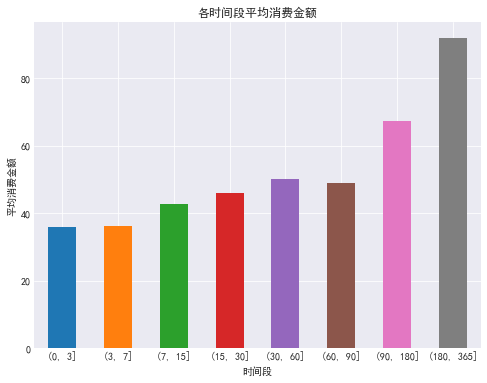

In [34]:
pivoted_retention.mean().plot.bar(figsize = (8,6),rot = 0)
plt.title('各时间段平均消费金额')
plt.xlabel('时间段')
plt.ylabel('平均消费金额')
plt.show()

In [35]:
#1代表有消费，0代表没有消费
pivoted_retention_tran = pivoted_retention.applymap(lambda x: 1 if x > 0 else 0)
pivoted_retention_tran[:5]

diffed_bin,"(0, 3]","(3, 7]","(7, 15]","(15, 30]","(30, 60]","(60, 90]","(90, 180]","(180, 365]"
id,,,,,,,,
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,1
4,0,0,0,1,0,0,0,1
5,0,0,1,0,1,0,1,1


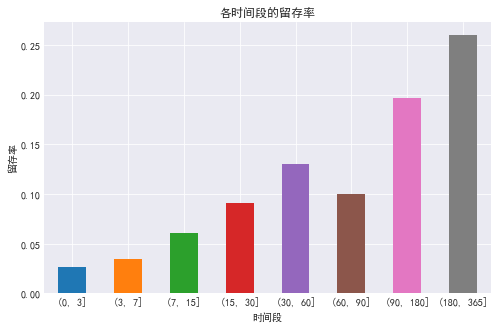

In [36]:
#计算留存率，并画出条形图
(pivoted_retention_tran.sum() / pivoted_retention_tran.count()).plot.bar(rot = 0,figsize = (8,5))
plt.title('各时间段的留存率')
plt.xlabel('时间段')
plt.ylabel('留存率')
plt.show()

只有2.5%的用户在第一次消费后的3天内有过消费，3%左右的用户在3-7天内有过消费。时间段越往后，留存率越高。

In [37]:
#定义一个函数，求出每个用户连续两次的消费间隔
def diff(df):
    a = df.diffed - df.diffed.shift(-1)
    return a

last_diff = id_retention.groupby('id').apply(diff)
last_diff[:10]

id   
1   0      NaN
2   1      0.0
    2      NaN
3   3    -87.0
    4     -3.0
    5   -227.0
    6    -10.0
    7   -184.0
    8      NaN
4   9    -17.0
Name: diffed, dtype: float64

In [38]:
#用户平均消费间隔
last_diff.mean()

-68.97376814424265

用户的平均消费间隔是68天，最好在60天左右的时间召回用户。

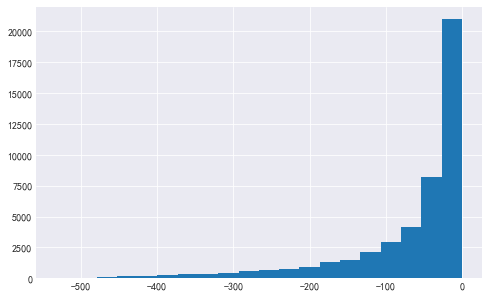

In [39]:
last_diff.hist(bins = 20,figsize = (8,5))
plt.show()

长尾分布，大部分用户的消费间隔比较短。